# Lab 2. Data Analytics Using PySpark
## Scalable and Distributed Computing
Sara Dovalo del Río, Alejandra Estrada Sanz and Luis Ángel Rodríguez García

### Part I
#### PySpark environment setup

In [60]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import LongType, TimestampType, IntegerType, DoubleType, StringType
from pyspark.sql.functions import when, count, col, countDistinct, desc, first, lit, to_date, max, min, mean, hour, dayofyear, dayofweek, month
from IPython.display import display, Markdown
import findspark

findspark.init()

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

seed_value = 100469000


In [61]:
custom_schema = StructType([StructField('VendorID', LongType(), False),
                     StructField('tpep_pickup_datetime', TimestampType(), False),
                     StructField('tpep_dropoff_datetime', TimestampType(), False),
                     StructField('passenger_count', IntegerType(), False),
                     StructField('trip_distance', DoubleType(), False),
                     StructField('rateCodeId', IntegerType(), False),
                     StructField('store_and_fwd_flag', StringType(), False),
                     StructField('PULocationID', StringType(), False),
                     StructField('DOLocationID', StringType(), False),         
                     StructField('payment_type', IntegerType(), False),
                     StructField('fare_amount', DoubleType(), False),
                     StructField('extra', DoubleType(), False),
                     StructField('mta_tax', DoubleType(), False),
                     StructField('tip_amount', DoubleType(), False),
                     StructField('tolls_amount', DoubleType(), False),
                     StructField('improve_surcharge', DoubleType(), False),
                     StructField('total_amount', DoubleType(), False)])

cab_trips = spark.read \
                .schema(custom_schema) \
                .option('header', 'true') \
                .csv('data/*.csv')



cab_trips.printSchema()
display(Markdown("This DataFrame has **%d rows**." % (cab_trips.count())))

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- rateCodeId: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improve_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



This DataFrame has **1942420 rows**.

We are going to use the method `cache` to do the optimization of the dataset in order to do the processing faster. Later on, we are going to generate a random sample of the ten percent of the rows without replacemant and select the two first rows.

In [62]:
cab_trips.cache()
cab_trips.sample(False, 0.1, seed_value).take

22/03/18 13:17:36 WARN CacheManager: Asked to cache already cached data.


<bound method DataFrame.take of DataFrame[VendorID: bigint, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: int, trip_distance: double, rateCodeId: int, store_and_fwd_flag: string, PULocationID: string, DOLocationID: string, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improve_surcharge: double, total_amount: double]>

As we can see above, pyspark implements lazy operations, that means that nothing is executed until some commands such as `take`, `collect` or `show` are executed.

#### Journey type analysis

Now, we want to know more information about the journey data, what's the payment method used on the longest trip in average?

In [54]:
t1 = cab_trips.agg(max('tpep_dropoff_datetime').alias('max_dropoff')).collect()[0]['max_dropoff']
t2 = cab_trips.agg(min('tpep_dropoff_datetime').alias('min_dropoff')).collect()[0]['min_dropoff']
print('Dates from {} to {}'.format(t1, t2))

cab_trips_group = cab_trips.groupby('payment_type').agg(mean('trip_distance').alias('avg_trip_distance')).sort(col('avg_trip_distance').desc())
cab_trips_group.show()
payment_highest_distance =  cab_trips_group.first().payment_type
print('The payment with the highest average distance is {}'.format(payment_highest_distance))

Dates from 2017-02-24 22:04:42 to 2017-01-01 00:00:00
+------------+------------------+
|payment_type| avg_trip_distance|
+------------+------------------+
|           1|2.9959558764164433|
|           4| 2.775850239763924|
|           3|2.7320917450586597|
|           2|2.5783104527575085|
+------------+------------------+

The payment with the highest average distance is 1


#### Average distance during each part of the day 

In this case, what we want to know is the average distance depending on the part of the day: morning, afternoon, evening, night and late night.

In [73]:
time_results = cab_trips.withColumn('hour', hour(cab_trips.tpep_pickup_datetime)) \
                        .withColumn('day', dayofyear(cab_trips.tpep_pickup_datetime)) \
                        .withColumn('wday', dayofweek(cab_trips.tpep_pickup_datetime)) \
                        .withColumn('month', month(cab_trips.tpep_pickup_datetime))

morning = time_results.filter((col('hour') >= 7) & (col('hour') <12))
afternoon = time_results.filter((col('hour') >= 12) & (col('hour') <16))
evening = time_results.filter((col('hour') >= 16) & (col('hour') <18))
night = time_results.filter((col('hour') >= 18) & (col('hour') <=23))
latenight = time_results.filter((col('hour') >= 0) & (col('hour') < 7))

print("During mornings (from 7am to 9 am), the average distance is {:0.2f} miles".format(morning.agg(mean('trip_distance').alias('avg_trip_distance')).first()['avg_trip_distance']))
print("During afternoon (from 12m and 4pm), the average distance is {:0.2f} miles".format(afternoon.agg(mean('trip_distance').alias('avg_trip_distance')).first()['avg_trip_distance']))
print("During evening (from 4pm to 6pm), the average distance is {:0.2f} miles".format(evening.agg(mean('trip_distance').alias('avg_trip_distance')).first()['avg_trip_distance']))
print("During nights (from 6pm to 12pm), the average distance is {:0.2f} miles".format(night.agg(mean('trip_distance').alias('avg_trip_distance')).first()['avg_trip_distance']))
print("During late nights (from 12pm to 7 am), the average distance {:0.2f} miles".format(latenight.agg(mean('trip_distance').alias('avg_trip_distance')).first()['avg_trip_distance']))

During mornings (from 7am to 9 am), the average distance is 2.53 miles
During afternoon (from 12m and 4pm), the average distance is 2.80 miles
During evening (from 4pm to 6pm), the average distance is 2.84 miles
During nights (from 6pm to 12pm), the average distance is 2.88 miles
During late nights (from 12pm to 7 am), the average distance 3.34 miles


#### Frequency of the number of passenger

In this case, we want to know how many passengers in a trip are the most frequent.

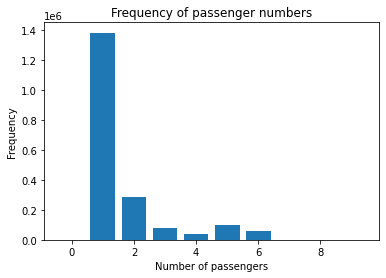

In [81]:
import matplotlib.pyplot as plt

passengers = cab_trips.groupBy('passenger_count') \
                      .agg(count('passenger_count') \
                      .alias("counts_passenger")) \
                      .sort(col('counts_passenger').desc())
data = passengers.toPandas()
plt.bar(x=data['passenger_count'], height=data['counts_passenger'])
plt.xlabel('Number of passengers')
plt.ylabel('Frequency')
plt.title('Frequency of passenger numbers')
plt.show()

#### Max trip distance based on the number of passengers

In this case, we want to know the maximum distance of a trip based on the number of passengers

Text(0.5, 1.0, 'Max trip distance depending on the number of passengers')

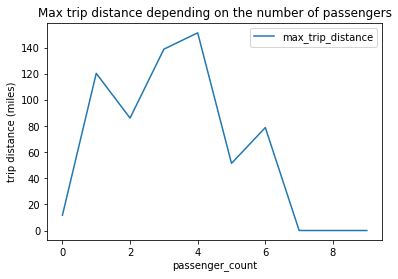

In [90]:
passenger_vs_distance = cab_trips.groupby('passenger_count').agg(max(col('trip_distance')).alias('max_trip_distance')).sort(col('passenger_count').asc())
passenger_df = passenger_vs_distance.toPandas()
passenger_df.plot(x='passenger_count', y='max_trip_distance')
plt.ylabel("trip distance (miles)")
plt.title('Max trip distance depending on the number of passengers')